In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

### Designing the Kalman Filter

Modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

In [98]:
def parameters(T=200,cov_q_const=1,cov_r_const=100):
    A = np.identity(4)
    A[0,2], A[1,3] = 1,1                              # VERIFY THIS!!! (Time steps are not included!)

    B = np.array([[1/2,0],[0,1/2],[1,0],[0,1]])     # VERIFY THIS!!!  (Should be 1/2 * a * t^2 )

    meu_q = np.zeros((4))
    cov_q = np.identity(4)
    cov_q[2,2],cov_q[3,3] = 0.0001,0.0001
    cov_q*=cov_q_const
    # To genrate => ep = np.random.multivariate_normal(meu_q,cov_q,N)

    C = np.array([[1,0,0,0],[0,1,0,0]])
    meu_r = np.zeros((2))
    cov_r = cov_r_const*np.identity(2)
    # To genrate => ep = np.random.multivariate_normal(meu_r,cov_r,N)

    #T = 200     # Total time steps
    
    return (A,B,meu_q,cov_q,C,meu_r,cov_r,T)

# A,B,meu_q,cov_q,C,meu_r,cov_r,T = parameters()
# params = parameters()

### 2. (a)  Simulate motion and sensor model, and plot the actual and observed trajectory.

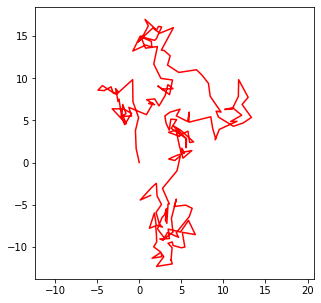

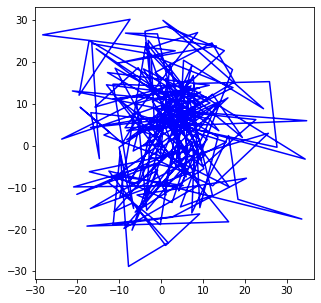

In [99]:
def zero_initializer(T=200):
    del_xy = np.zeros((T,2))
    X = np.zeros((4))
    return(del_xy,X)


def time_series(U, X_init , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    # Assuming deltax and deltay are 0         # CAN/DO WE MAKE THIS ASSUMPTION
    del_xy = U
    
    ep_q = np.random.multivariate_normal(meu_q,cov_q)
    ep_r = np.random.multivariate_normal(meu_r,cov_r)
    
    X = np.zeros((T,4))
    X[0,:] = X_init
    X_obs = np.zeros((T,2))
    X_obs[0,:] = np.dot(C,X[0,:]) + ep_r
    
    
    
    X_obs[0,:] = np.random.multivariate_normal(meu_r,cov_r)


    for i in range(1,T):
        ep_q = np.random.multivariate_normal(meu_q,cov_q)
        X[i,:] = np.dot(A,X[i-1,:])+np.dot(B,del_xy[i-1,:]) + ep_q

        ep_r = np.random.multivariate_normal(meu_r,cov_r)
        X_obs[i,:] = np.dot(C,X[i,:]) + ep_r
    
    return (X,X_obs)

def time_series_X(U, X_init , A,B,meu_q,cov_q):
    
    del_xy = U
    
    X = np.zeros((T,4))
    X[0,:] = X_init

    for i in range(1,T):
        ep_q = np.random.multivariate_normal(meu_q,cov_q)
        X[i,:] = np.dot(A,X[i-1,:])+np.dot(B,del_xy[i-1,:]) + ep_q
    
    return (X)

def time_series_X_obs(U, X , A,B,meu_r,cov_r):

    # Assuming deltax and deltay are 0         # CAN/DO WE MAKE THIS ASSUMPTION
    del_xy = U

    ep_r = np.random.multivariate_normal(meu_r,cov_r)

    X_obs = np.zeros((T,2))
    X_obs[0,:] = np.dot(C,X[0,:]) + ep_r
    X_obs[0,:] = np.random.multivariate_normal(meu_r,cov_r)


    for i in range(1,T):
        ep_r = np.random.multivariate_normal(meu_r,cov_r)
        X_obs[i,:] = np.dot(C,X[i,:]) + ep_r
    
    return (X_obs)

def plotter(X,plot_siz=20,clr='r'):
    
    x, y = X[:,0],X[:,1]
    plt.figure(figsize=(plot_siz, plot_siz))
    plt.plot(x, y, color=clr)
    plt.axis('equal')
    plt.show()


params = parameters()
del_xy,X_init = zero_initializer()
X,X_obs = time_series(del_xy,X_init,params)
plotter(X,plot_siz=5)
plotter(X_obs,plot_siz=5,clr='b')

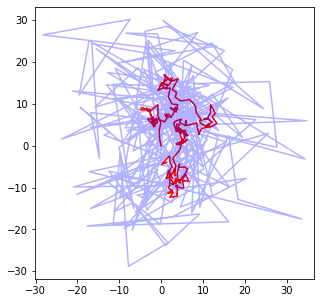

In [100]:
x1, y1 = X[:,0],X[:,1]
x2, y2 = X_obs[:,0],X_obs[:,1]
plt.figure(figsize=(5, 5))
plt.plot(x1, y1, color='r')
plt.plot(x2, y2, color='b',alpha=0.3)
plt.axis('equal')
plt.show()

### 2.(b) Estimation of Vehicle state
We use Kalman filter form of Baye's filter for the implementing the estimation of the vehicle's state.

As mentioned before, modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

###### Dynamic Update:
$$ \bar{\mu} = A*X\_bel\_\mu_{i-1} + B*U $$
$$ \bar{\Sigma} = A*X\_bel\_\Sigma_{i-1}*A^{T} + Cov\_matrix(\epsilon_{t}) $$

###### Measurement Update:
$$ R = \bar{\Sigma}C^{T}(C\bar{\Sigma}C^{T}+R) + Cov\_matrix(\delta_{t})$$
$$ X\_bel\_\mu_{i} = \bar{\mu} + K(Z_{t}-C\bar{\mu}) $$
$$ X\_bel\_\Sigma_{i} = (I - KC)\bar{\Sigma} $$

In [101]:
params = parameters()
del_xy,X_init = zero_initializer()
X_init = np.array([10,10,1,1])
X,X_obs = time_series(del_xy,X_init,params)

In [102]:
def Kalman_Filter(meu_prev,cov_prev,U,Z,params,obs=True):
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    # Dynamics Update:
    meu_temp = np.dot(A,meu_prev) + np.dot(B,U)
    cov_temp = np.dot(np.dot(A,cov_prev),A.T) + cov_q
    # Measurement Update:
    if(not obs):
        return (meu_temp,cov_temp)
    K = np.dot( np.dot( cov_temp,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp),C.T) + cov_r) )
    meu = meu_temp + np.dot(K,Z-np.dot(C,meu_temp))
    KC_calc = np.dot(K,C)
    cov = np.dot(np.identity(KC_calc.shape[0]) - KC_calc , cov_temp)
    
    return (meu,cov)
    
def state_estimation(U , X , X_obs , params , drop_out_intervals = [] , drop_out_duration = 0 , cov_const = 0.0001):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    
    X_init = X[0,:]
    X_belief_meu = np.zeros((T,X.shape[1]))
    X_belief_cov = np.zeros((T,X.shape[1],X.shape[1]))
    
    #X_belief_meu[0,:] = np.random.multivariate_normal(X_init , 0.0001*np.identity(4))
    X_belief_meu[0,:] = X_init
    X_belief_cov[0,:] = cov_const*np.identity(X.shape[1])
    
    i = 1
    liter = 0
    while(i<T):
        if(liter<len(drop_out_intervals) and i==drop_out_intervals[liter]):
            liter+=1
            for i in range(drop_out_duration):
                X_belief_meu[i,:],X_belief_cov[i,:] = Kalman_Filter(X_belief_meu[i-1,:],X_belief_cov[i-1,:],U[i-1,:],X_obs[i-1],params,obs=False)
                i+=1
                if(i>=T): break
        else:
            X_belief_meu[i,:],X_belief_cov[i,:] = Kalman_Filter(X_belief_meu[i-1,:],X_belief_cov[i-1,:],U[i-1,:],X_obs[i-1],params,obs=True)
            i+=1
        
    return (X_belief_meu,X_belief_cov)

X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params)


### 2.(c) Plot the Actual Trajectory, Noisy Observations, Estimated Tragectory (produced by filter). Also plot, uncertainty ellipse for the estimated trajectory
An uncertainty ellipse denotes the locus of points that are one standard deviation away from the mean.

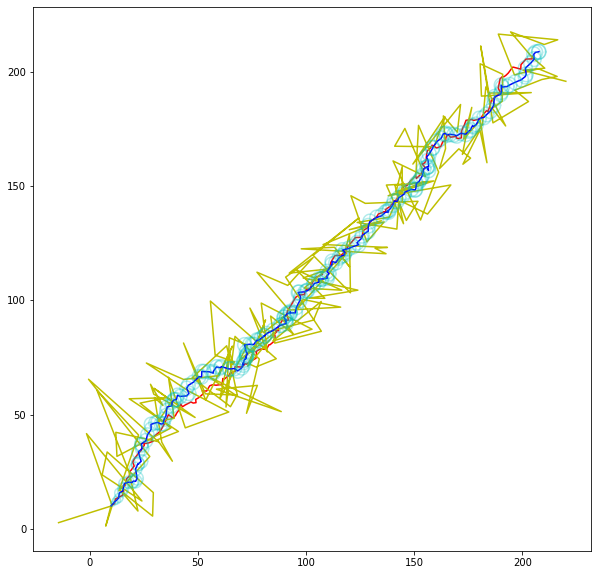

In [103]:
def ellipse_plotter(x,y,rx,ry,clr='c',a=0.3):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = x+rx*np.cos(theta)
    x2 = y+ry*np.sin(theta)
    plt.plot(x1,x2,color=clr,alpha=a)

def uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov):
    for i in range(X.shape[0]):
        ellipse_plotter( X_pred_meu[i,0],X_pred_meu[i,1]
                       ,math.sqrt(X_pred_cov[i,0,0])
                       ,math.sqrt(X_pred_cov[i,1,1]))

    
    
def multiplotter(X1,X2,X3, plot_siz=20):
    x1, y1 = X1[:,0],X1[:,1]
    x2, y2 = X2[:,0],X2[:,1]
    x3, y3 = X3[:,0],X3[:,1]
    plt.figure(figsize=(plot_siz, plot_siz))
    plt.plot(x1, y1, color='r')
    plt.plot(x2, y2, color='y')
    plt.plot(x3, y3, color='b')
    

multiplotter(X,X_obs,X_pred_meu,plot_siz=10)
uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov)
plt.show()

### 2.(d) Implement Control Policy. Plot true, observed, estimated trajectories. Compute and plot error-
Implement a control policy where $\delta \dot{x_t}$ varies as a sine wave and $\delta \dot{y_t}$ varies as a cosine wave. Plot the true, observed and the estimated $x_{t}$, $y_{t}$ trajectories under the given control inputs. Compute and plot the error between the true and the estimated trajectory using the euclidean distance metric.


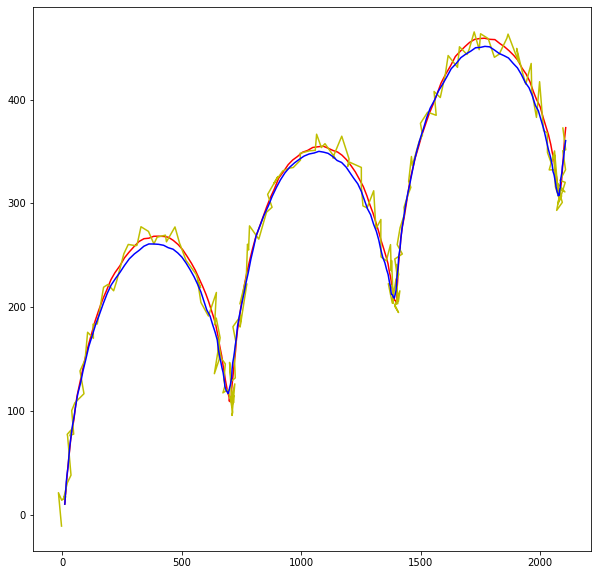

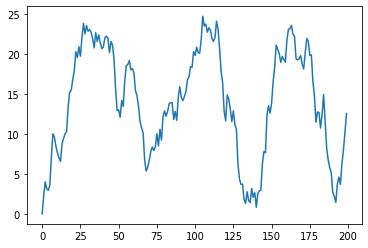

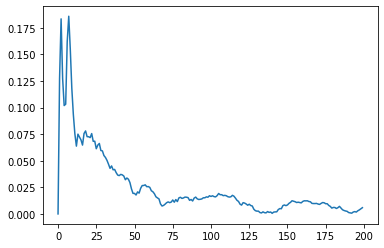

In [104]:
def sin_cos_init():
    sinusoid_producers = 0.1*np.arange(T)
    del_xy = np.hstack((np.sin(sinusoid_producers).reshape(-1,1),np.cos(sinusoid_producers).reshape(-1,1)))
    return del_xy

def cos_sin_init():
    sinusoid_producers = 0.1*np.arange(T)
    del_xy = np.hstack((np.cos(sinusoid_producers).reshape(-1,1),np.sin(sinusoid_producers).reshape(-1,1)))
    return del_xy

def vector_norm(X):
    Xn = np.sqrt(np.sum(np.square(X),axis=1))
    return Xn

def Euc_error(X,X_pred_meu):
    X_err = vector_norm(X-X_pred_meu)
    return X_err


params = parameters(200)
A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

del_xy = sin_cos_init()
X_init = np.array([10,10,1,1])

X,X_obs = time_series(del_xy,X_init,params)
X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params)
multiplotter(X,X_obs,X_pred_meu,10)
#uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)
plt.show()

X_err = Euc_error(X,X_pred_meu)
plt.plot(np.arange(X_err.shape[0]),X_err)
plt.show()

# Relative error
X_err_rel = Euc_error(X,X_pred_meu) / vector_norm(X)
plt.plot(np.arange(X_err_rel.shape[0]),X_err_rel)
plt.show()

### 2.(e) Experiment with changes in uncertainty in sensor model-
Increase and decrease the uncertainty in the sensor model in comparison with the uncertainty in the motion model. Plot the estimated trajectory and explain how the noise variation impacts the filter performance.

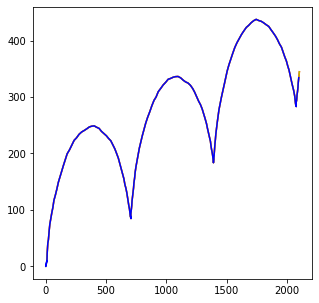

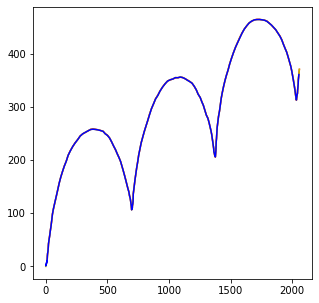

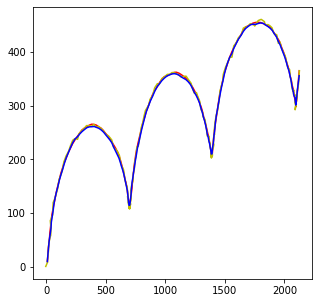

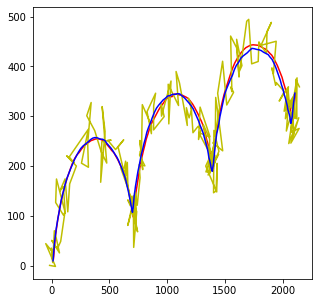

In [105]:
del_xy,X_init = zero_initializer()
del_xy = sin_cos_init()
X_init = np.array([10,10,1,1])


def plot_uncertainty_sensor_models(del_xy,X_init,cov_r_const = 100, plot_siz=10):
    
    params = parameters(200,cov_r_const = cov_r_const)
    X,X_obs = time_series(del_xy,X_init,params)
    X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params)
    multiplotter(X,X_obs,X_pred_meu, plot_siz)
    #uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)
    plt.show()
    #plotter(X)

for i in np.arange(-3,5,2):
    temp=0
    if(i<0):
        temp = 1/(10**(-1*i))
    else:
        temp = 10**i
    plot_uncertainty_sensor_models(del_xy,X_init,cov_r_const=temp, plot_siz=5
                                  )
    

### 2.(f) Experiment with changes in uncertainty in initial belief-
Next, model higher uncertainty in the initial belief over the vehicle’s position assuming a standard deviation of 100 in both the x and y positions. As before, plot the true, observed and the estimated trajectories under the sine-cosine control policy.

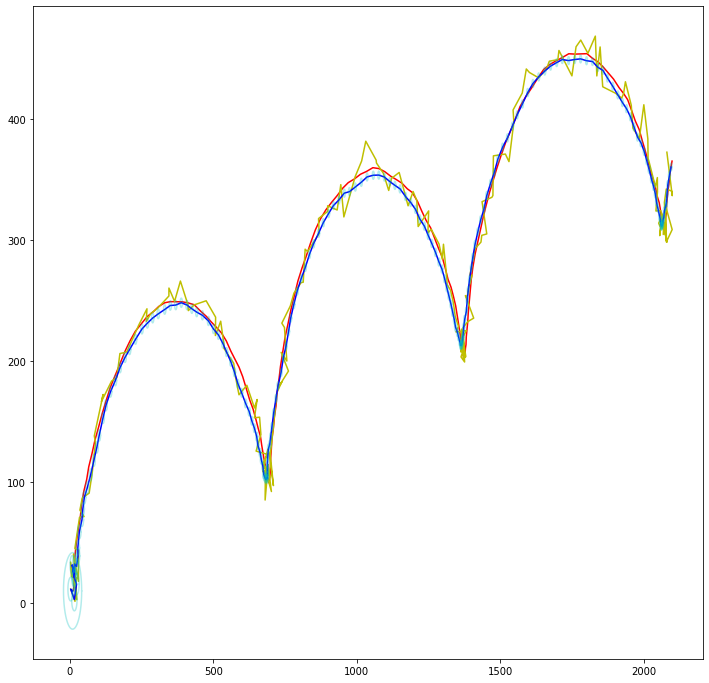

'\nfor i in np.arange(-6,10,13):\n    temp=0\n    if(i<0):\n        temp = 1/(10**(-1*i))\n    else:\n        temp = 10**i\n    plot_uncertainty_init_belief(bel=temp, plot_siz=12)\n'

In [106]:
def plot_uncertainty_init_belief(bel,plot_siz=5):
    del_xy,X_init = zero_initializer()
    del_xy = sin_cos_init()
    X_init = np.array([10,10,1,1])
    params = parameters(200)
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    X,X_obs = time_series(del_xy,X_init,params)
    X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params , cov_const = bel)
    multiplotter(X,X_obs,X_pred_meu, plot_siz)
    uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov)
    plt.show()
    #plotter(X)

plot_uncertainty_init_belief(bel=1000, plot_siz=12)
'''
for i in np.arange(-6,10,13):
    temp=0
    if(i<0):
        temp = 1/(10**(-1*i))
    else:
        temp = 10**i
    plot_uncertainty_init_belief(bel=temp, plot_siz=12)
'''

In [107]:
'''
del_xy,X_init = zero_initializer()
del_xy = sin_cos_init()
X_init = np.array([10,10,1,1])
p = parameters()
X = time_series_X(del_xy, X_init, p[0],p[1],p[2],p[3])


def plot_uncertainty_init_belief(X, del_xy, cv = 0.0001 , plot_siz=5):
    params = parameters(200,cov_r_const=cv)
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    X_obs =  time_series_X_obs(del_xy,X,A,B,meu_r,cov_r)

    X,X_obs = time_series(del_xy,X_init,params)
    X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params , cov_const = cv)
    #multiplotter(X,X_obs,X_pred_meu, plot_siz)
    #uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)
    plt.show()

for i in np.arange(-6,100,15):
    temp=0
    if(i<0):
        temp = 1/(10**(-1*i))
    else:
        temp = 10**i
    plot_uncertainty_init_belief(X, del_xy, cv=temp, plot_siz=12)
'''

'\ndel_xy,X_init = zero_initializer()\ndel_xy = sin_cos_init()\nX_init = np.array([10,10,1,1])\np = parameters()\nX = time_series_X(del_xy, X_init, p[0],p[1],p[2],p[3])\n\n\ndef plot_uncertainty_init_belief(X, del_xy, cv = 0.0001 , plot_siz=5):\n    params = parameters(200,cov_r_const=cv)\n    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params\n    X_obs =  time_series_X_obs(del_xy,X,A,B,meu_r,cov_r)\n\n    X,X_obs = time_series(del_xy,X_init,params)\n    X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params , cov_const = cv)\n    #multiplotter(X,X_obs,X_pred_meu, plot_siz)\n    #uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)\n    plt.show()\n\nfor i in np.arange(-6,100,15):\n    temp=0\n    if(i<0):\n        temp = 1/(10**(-1*i))\n    else:\n        temp = 10**i\n    plot_uncertainty_init_belief(X, del_xy, cv=temp, plot_siz=12)\n'

### 2.(g) Sensor observations drop out
Assume that the sensor observations drop out at time instants t = 10 and t = 30 for a period of 10
time steps and are re-acquired after that period. Simulate and show the evolution of uncertainty in
the vehicle’s ($x_t$, $y_t$) position by plotting the uncertainty ellipses.

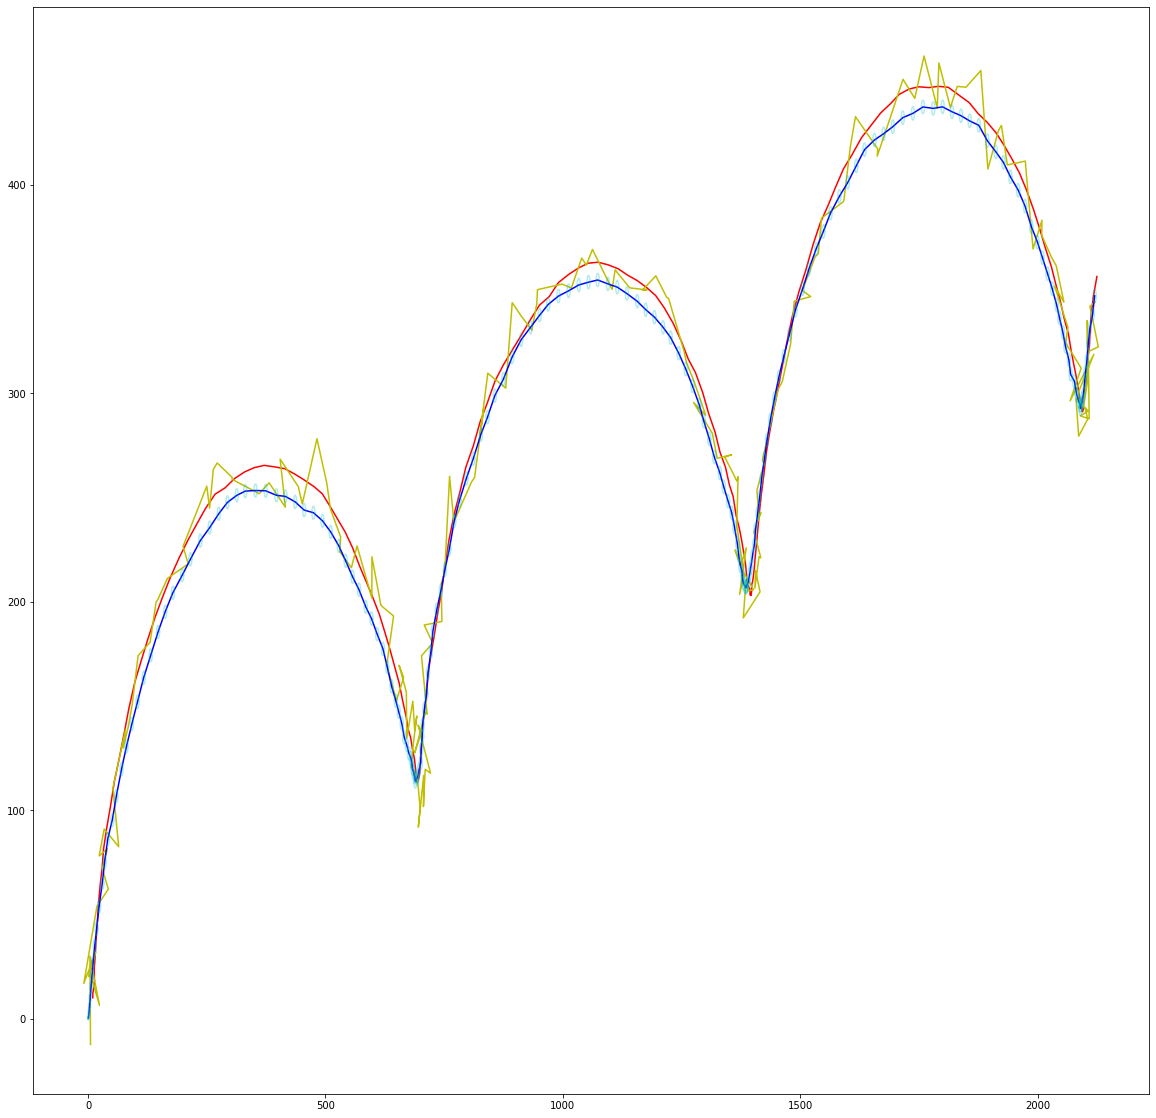

In [108]:
def sensor_obs_drop_out(drop_out_intervals,drop_out_duration,plot_siz=5):
    del_xy,X_init = zero_initializer()
    del_xy = sin_cos_init()
    X_init = np.array([10,10,1,1])
    params = parameters(200)
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    X,X_obs = time_series(del_xy,X_init,params)
    X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params , drop_out_intervals,drop_out_duration)
    multiplotter(X,X_obs,X_pred_meu, plot_siz)
    uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov)
    plt.show()
    #plotter(X)


doi = [10,30]
dod = 10
sensor_obs_drop_out(doi,dod,plot_siz=20)

### 2.(h) Velocity plot
Plot the estimated velocities ($\hat{\dot{x}}$, $\hat{\dot{y}}$) and the true velocities of the vehicle ($\dot{x_{t}}$, $\dot{y_{t}}$). Briefly explain if the estimator can or cannot track the true values.

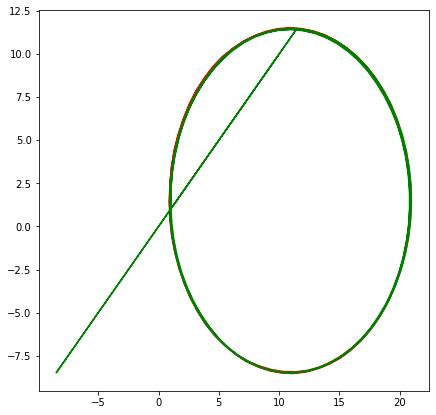

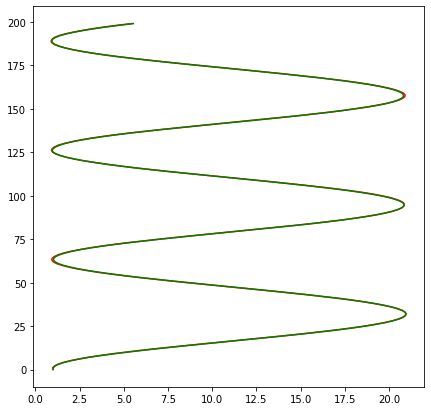

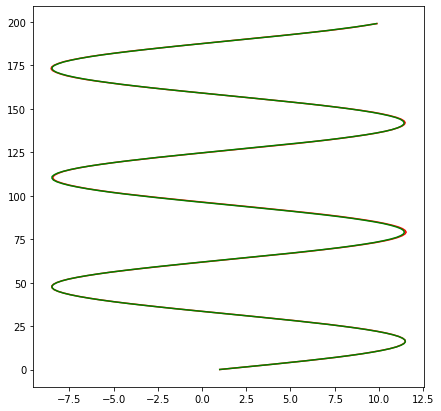

In [109]:
def velocity_plotter(plot_siz=10):
    del_xy,X_init = zero_initializer()
    del_xy = sin_cos_init()
    X_init = np.array([10,10,1,1])
    params = parameters(200)
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    X,X_obs = time_series(del_xy,X_init,params)
    #print(X.shape)
    X_pred_meu,X_pred_cov = state_estimation( del_xy , X , X_obs , params )
    plt.figure(figsize=(plot_siz, plot_siz))
    plt.plot(X[:,2],X[:,3],color = 'r')
    plt.plot(X_pred_meu[:,2:],X_pred_meu[:,3:],color = 'g')
    #uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov)
    plt.show()
    
    plt.figure(figsize=(plot_siz, plot_siz))
    plt.plot(X[:,2],np.arange(X.shape[0]),color = 'r')
    plt.plot(X_pred_meu[:,2],np.arange(X_pred_meu.shape[0]),color = 'g')
    plt.show()
    
    plt.figure(figsize=(plot_siz, plot_siz))
    plt.plot(X[:,3],np.arange(X.shape[0]),color = 'r')
    plt.plot(X_pred_meu[:,3],np.arange(X_pred_meu.shape[0]),color = 'g')
    plt.show()
    
velocity_plotter(7)

### 2.(i) Multi-agent modelling

Here, we consider that both the agents are starting from the same point and their paths differ due to different velocity vectors

<ipython-input-110-178368029c18>:34: RuntimeWarning: invalid value encountered in true_divide
  p = (p11*p22)/(p11*p22+p12*p21)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


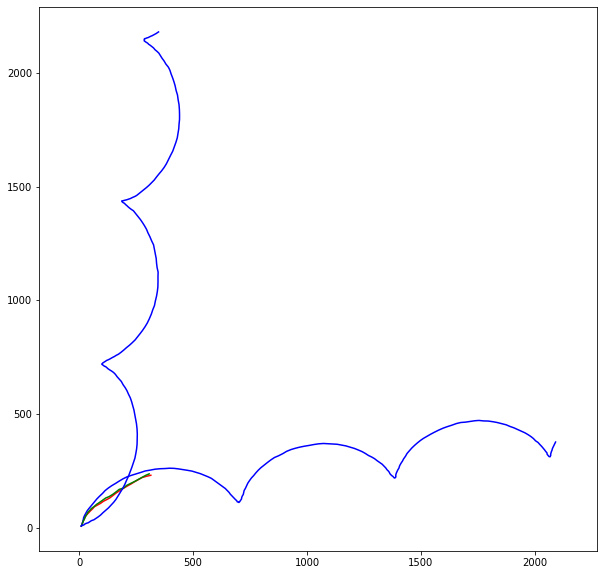

In [110]:
def find_prob(Z,meu,sigma):
    # Using mulitvariate normal distribution formula
    n = Z.shape[0]
    
    sigma = sigma[:2,:2]
    meu = meu.reshape(-1,1)[:2,:]
    Z = Z.reshape(-1,1)
    #print(Z.shape,meu.shape,sigma.shape)
    det = np.linalg.det(sigma)
    p = 1 / ( ((2*math.pi)**(n/2)) * (det**0.5 )  )
    p *= np.exp( -0.5*np.dot(np.dot((Z-meu).T , np.linalg.inv(sigma)) , (Z-meu) ) )
    
    return p[0]
    

def Kalman_Filter_b(meu_prev_1,cov_prev_1,
                    meu_prev_2,cov_prev_2,
                    U1,U2,Z1,Z2,params,obs=True):
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    # Dynamics Update:
    meu_temp_1 = np.dot(A,meu_prev_1) + np.dot(B,U1)
    cov_temp_1 = np.dot(np.dot(A,cov_prev_1),A.T) + cov_q
    
    meu_temp_2 = np.dot(A,meu_prev_1) + np.dot(B,U2)
    cov_temp_2 = np.dot(np.dot(A,cov_prev_2),A.T) + cov_q
    
    # Calc probabilities:
    # pij : prob of meui, covi to get the point j
    p11 = find_prob(Z1,meu_temp_1,cov_temp_1)
    p12 = find_prob(Z2,meu_temp_1,cov_temp_1)
    p21 = find_prob(Z1,meu_temp_2,cov_temp_2)
    p22 = find_prob(Z2,meu_temp_2,cov_temp_2)
    
    p = (p11*p22)/(p11*p22+p12*p21)
    
    # If no measurements:
    if(not obs):
        return (meu_temp,cov_temp)
    
    # Measurement Update:
    K_1_1 = np.dot( np.dot( cov_temp_1,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp_1),C.T) + cov_r) )
    meu_1_1 = meu_temp_1 + np.dot(K_1_1,Z1-np.dot(C,meu_temp_1))
    KC_calc_1_1 = np.dot(K_1_1,C)
    cov_1_1 = np.dot(np.identity(KC_calc_1_1.shape[0]) - KC_calc_1_1 , cov_temp_1)
    
    K_1_2 = np.dot( np.dot( cov_temp_1,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp_1),C.T) + cov_r) )
    meu_1_2 = meu_temp_1 + np.dot(K_1_2,Z2-np.dot(C,meu_temp_1))
    KC_calc_1_2 = np.dot(K_1_2,C)
    cov_1_2 = np.dot(np.identity(KC_calc_1_2.shape[0]) - KC_calc_1_2 , cov_temp_1)
    
    K_2_1 = np.dot( np.dot( cov_temp_2,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp_2),C.T) + cov_r) )
    meu_2_1 = meu_temp_2 + np.dot(K_2_1,Z1-np.dot(C,meu_temp_2))
    KC_calc_2_1 = np.dot(K_2_1,C)
    cov_2_1 = np.dot(np.identity(KC_calc_2_1.shape[0]) - KC_calc_2_1 , cov_temp_2)
    
    K_2_2 = np.dot( np.dot( cov_temp_2,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp_2),C.T) + cov_r) )
    meu_2_2 = meu_temp_2 + np.dot(K_2_1,Z2-np.dot(C,meu_temp_2))
    KC_calc_2_2 = np.dot(K_2_2,C)
    cov_2_2 = np.dot(np.identity(KC_calc_2_2.shape[0]) - KC_calc_2_2 , cov_temp_2)
    
    meu_1 = p*meu_1_1 + (1-p)*(meu_1_2)
    meu_2 = p*meu_2_2 + (1-p)*(meu_2_1)
    cov_1 = p*cov_1_1 + (1-p)*(cov_1_2)
    cov_2 = p*cov_2_2 + (1-p)*(cov_2_1)
    
    
    return (meu_1,meu_2,cov_1,cov_2)
    
def state_estimation_b(U_1,U_2, X_1,X_2,X_obs_1,X_obs_2,params, drop_out_intervals=[], drop_out_duration=0, cov_const=0.0001):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    
    X_init_1 = X_1[0,:]
    X_belief_meu_1 = np.zeros((T,X_1.shape[1]))
    X_belief_cov_1 = np.zeros((T,X_1.shape[1],X_1.shape[1]))
    X_belief_meu_1[0,:] = X_init_1
    X_belief_cov_1[0,:] = cov_const*np.identity(X_1.shape[1])
    
    X_init_2 = X_1[0,:]
    X_belief_meu_2 = np.zeros((T,X_2.shape[1]))
    X_belief_cov_2 = np.zeros((T,X_2.shape[1],X_2.shape[1]))
    X_belief_meu_2[0,:] = X_init_2
    X_belief_cov_2[0,:] = cov_const*np.identity(X_2.shape[1])
    
    i = 1
    liter = 0
    while(i<T):
        if(liter<len(drop_out_intervals) and i==drop_out_intervals[liter]):
            liter+=1
            for i in range(drop_out_duration):
                X_belief_meu[i,:],X_belief_cov[i,:] = Kalman_Filter_b(X_belief_meu_1[i-1,:],X_belief_cov_1[i-1,:],
                                                                    X_belief_meu_2[i-1,:],X_belief_cov_2[i-1,:],
                                                                    U_1[i-1,:],U_2[i-1,:],X_obs_1[i-1],X_obs_2[i-1,:],
                                                                    params,obs=False)
                i+=1
                if(i>=T): break
        else:
            
            X_belief_meu_1[i,:],X_belief_meu_2[i,:],X_belief_cov_1[i,:],X_belief_cov_2[i,:] = Kalman_Filter_b(X_belief_meu_1[i-1,:],X_belief_cov_1[i-1,:],
                                                                X_belief_meu_2[i-1,:],X_belief_cov_2[i-1,:],
                                                                U_1[i-1,:],U_2[i-1,:],X_obs_1[i-1],X_obs_2[i-1,:],
                                                                params)
            i+=1
        
    return (X_belief_meu_1,X_belief_meu_2,X_belief_cov_1,X_belief_cov_2)


def multi_agents_modelling(num_of_agents=2, T=200):
    
    
    del_xy_1 = sin_cos_init()
    del_xy_2 = cos_sin_init()

    X_init_1 = np.array([10,10,1,1])
    X_init_2 = np.array([10,10,1,1])

    params = parameters(T)     

    X_1,X_obs_1 = time_series(del_xy_1,X_init_1,params)
    X_2,X_obs_2 = time_series(del_xy_2,X_init_2,params)

    X_pred_meu_1,X_pred_meu_2,X_pred_cov_1,X_pred_cov_2 = state_estimation_b( del_xy_1,del_xy_2,X_1,X_2,X_obs_1,X_obs_2,params )
    
    x1, y1 = X_pred_meu_1[:,0],X_pred_meu_1[:,1]
    x2, y2 = X_1[:,0],X_1[:,1]
    x3, y3 = X_pred_meu_2[:,0],X_pred_meu_2[:,1]
    x4, y4 = X_2[:,0],X_2[:,1]
    plt.figure(figsize=(10, 10))
    plt.plot(x1, y1, color='r')
    plt.plot(x2, y2, color='b')
    plt.plot(x3, y3, color='g')
    plt.plot(x4, y4, color='b')
    plt.axis('equal')
    plt.show()
    
multi_agents_modelling()